# Dynamic Time Warping
DTW follows a x-step process:
1. Select a window size with which to calculate DTW-distance between slices. In this program,
we select the number of observations _n_ into which the data should be divided, with a
window size of ```step = len(df) / n```. In order to prevent high degrees of dissimilarity
between the remaining data points not included in the window size, the first ```len(df) % step```
points are removed from the dataframe.
2. Calculate the DTW-distance between every pair of slices.
3. Utilize a custering algorithm (k-means) to

In [3]:
#Import Packages

import pandas as pd
import numpy as np
import math
import importlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from sklearn import preprocessing
import dtw
from utils.evaluating import evaluating_change_point

import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


In [12]:
#Load Files

all_files=[]
import os
for root, dirs, files in os.walk("../data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

dfs=[]
for path in all_files:
    df = pd.read_csv(path,sep=';', index_col='datetime', parse_dates=True)
    # df['datetime'] = df['datetime'].apply(pd.to_datetime)
    dfs.append(df)
print('Features:')
for col in dfs[1].columns:
    print('\t',col)

col_names = list(dfs[1].columns[0:8])

Features:
	 Accelerometer1RMS
	 Accelerometer2RMS
	 Current
	 Pressure
	 Temperature
	 Thermocouple
	 Voltage
	 Volume Flow RateRMS
	 anomaly
	 changepoint


In [4]:
# #Standardize Data
# dfs_stand = []
# for df in dfs:
#     scaler = preprocessing.StandardScaler()
#     scaler.fit(df[col_names])
#     dfs_stand.append(pd.DataFrame(data=scaler.transform(df[col_names]), index=df.index, columns=col_names))

NameError: name 'dfs' is not defined

In [18]:
# Split into n observations

def df_split(df, n):
    step = math.floor(len(df)/n)
    remainder = len(df) % step
    splits = [remainder]
    while max(splits) < len(df):
        splits.append(max(splits) + step)
    splits[-1] -= 1
    return splits

..\data\other\12.csv


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
count,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000
mean,0.081098,0.132212,1.573211,0.011449,86.980258,22.112552,230.035659,76.047435,0.350044,0.003518
std,0.000639,0.002566,0.385167,0.256350,0.857701,0.016770,11.052438,1.041825,0.477193,0.059235
min,0.079158,0.125210,0.598223,-0.601143,85.280200,22.078000,203.887000,74.000000,0.000000,0.000000
25%,0.080629,0.130171,1.296880,-0.273216,86.364100,22.099900,223.636000,75.000000,0.000000,0.000000
50%,0.081074,0.132053,1.654900,0.054711,86.824800,22.110100,230.496000,76.020100,0.000000,0.000000
75%,0.081548,0.134189,1.869030,0.054711,87.596400,22.126100,236.537000,77.000000,1.000000,0.000000
max,0.083113,0.138839,2.328460,0.710565,88.993500,22.155600,254.611000,78.000000,1.000000,1.000000


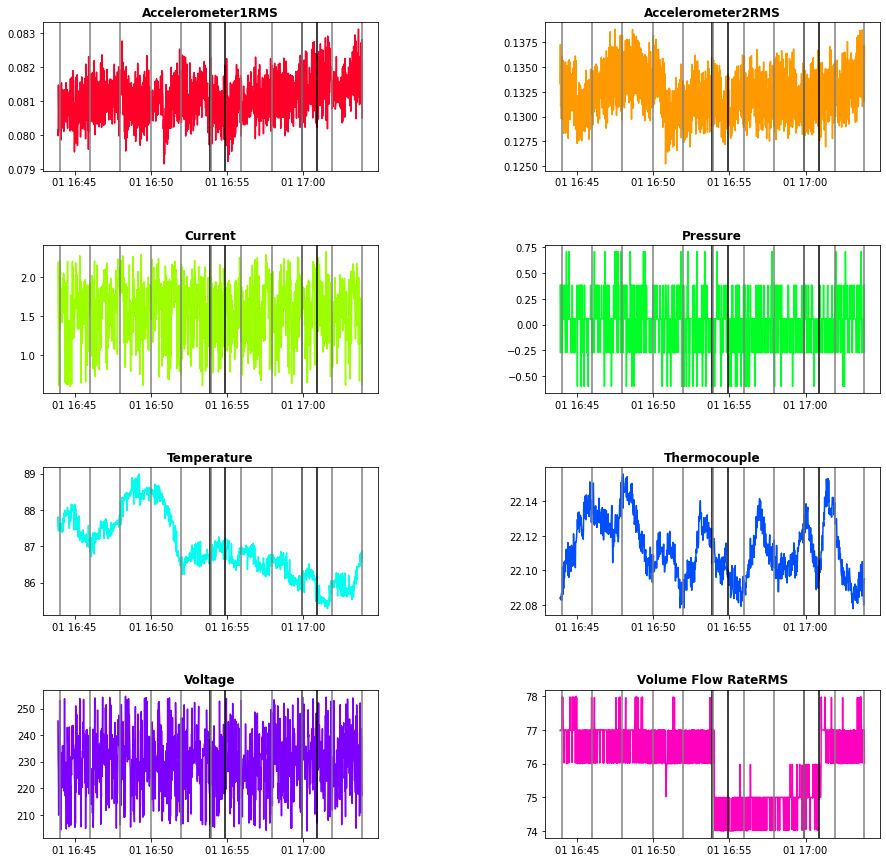

In [28]:
# Plot Data
experiments = [2]
for i in experiments:
    print(all_files[i].replace("/","\\"))
    display(dfs[i].describe())
    df = dfs[i]
    fig, axes = plt.subplots(nrows=4, ncols=2)
    color = iter(cm.gist_rainbow(np.linspace(0, 1, len(df.columns)-2)))
    points = df.index[df['changepoint'] == 1].tolist()
    splits = df.iloc[df_split(df, 10)].index

    for col, ax in zip(df.columns[0:8], axes.flatten()):
        c = next(color)
        ax.set_title(col, fontweight="bold")
        ax.plot(df[col], c=c)
        for p in points:
            ax.axvline(p, color="black")
        for split in splits:
            ax.axvline(split, color="gray")
        plt.subplots_adjust(wspace=.5, hspace=.5)
    fig.set_facecolor('white')
    fig.set_size_inches(15, 15)

In [ ]:
# DTW Attempt 1

In [41]:
def find_anomalies(squared_errors):
    # threshold = np.mean(squared_errors) + 5 * np.std(squared_errors)
    threshold = np.sort(squared_errors)[-4]
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold

#VAR Model
for df in dfs_stand:
    max_lag = 20
    var_model = VAR(df)
    lag_results = var_model.select_order(max_lag)
    selected_lag = lag_results.aic
    var_fitresults = var_model.fit(selected_lag)
    fits = var_fitresults.fittedvalues.copy()
    squared_errors = var_fitresults.resid.sum(axis=1) ** 2
    predictions, threshold = find_anomalies(squared_errors)
    df['Predictions'] = 0
    df['Predictions'].iloc[selected_lag:] = predictions.values

c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\asus\appdata\local\programs\python\python38\li

..\data\other\20.csv


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,0.238646,0.290395,2.418080,0.098214,85.137640,30.768303,227.525908,128.262455,0.378673,0.003359
std,0.004933,0.008191,0.495027,0.264646,0.357162,0.527378,10.930676,0.779631,0.485260,0.057880
min,0.226751,0.273341,0.933653,-1.257000,84.401000,29.960000,201.265000,125.312000,0.000000,0.000000
25%,0.235512,0.283859,2.133500,0.054711,84.850450,30.224800,221.739500,128.000000,0.000000,0.000000
50%,0.238227,0.288316,2.553740,0.054711,85.131600,30.744700,227.806000,128.312000,0.000000,0.000000
75%,0.241025,0.298242,2.756350,0.382638,85.360800,31.277700,234.011500,128.690000,1.000000,0.000000
max,0.257534,0.309150,3.296250,1.038490,86.006300,31.628800,251.138000,130.690000,1.000000,1.000000


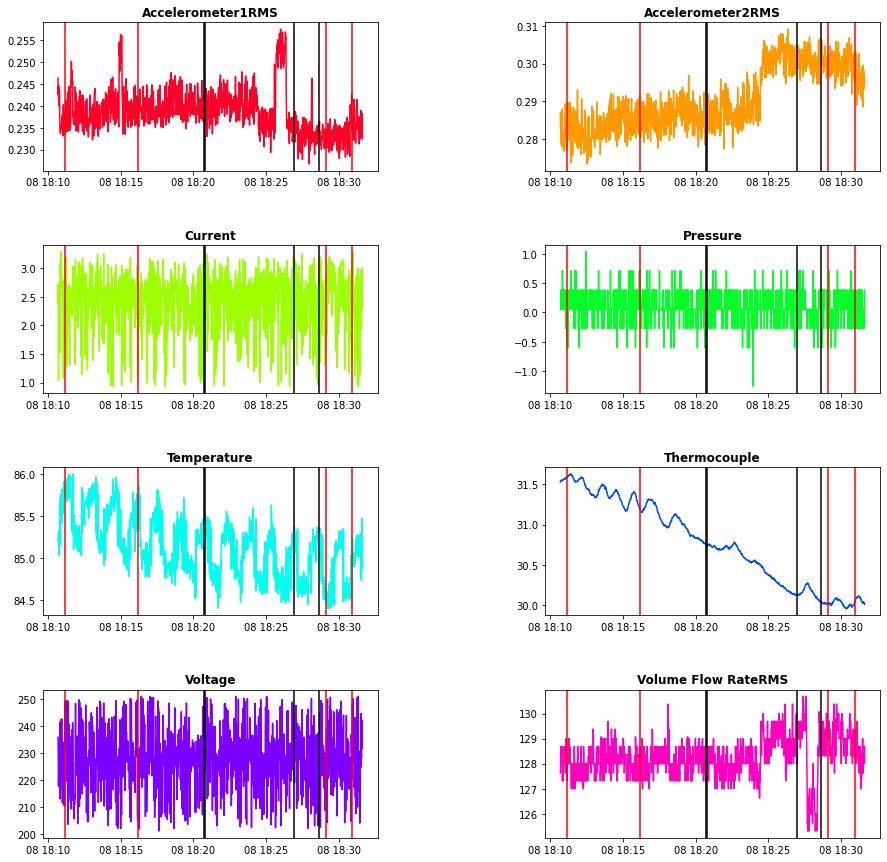

In [42]:
# Plot Anomalies
for i in experiments:
    print(all_files[i].replace("/","\\"))
    display(dfs[i].describe())
    df = dfs[i]
    fig, axes = plt.subplots(nrows=4, ncols=2)
    color = iter(cm.gist_rainbow(np.linspace(0, 1, len(df.columns)-2)))
    points = df.index[df['changepoint'] == 1].tolist()
    preds = dfs_stand[i].index[dfs_stand[i]['Predictions'] == 1].tolist()
    for col, ax in zip(df.columns[0:8], axes.flatten()):
        c = next(color)
        ax.set_title(col, fontweight="bold")
        ax.plot(df[col], c=c)
        for p in points:
            ax.axvline(p, color="black")
        for i in preds:
            ax.axvline(i, color="red")
        plt.subplots_adjust(wspace=.5, hspace=.5)
    fig.set_facecolor('white')
    fig.set_size_inches(15, 15)

In [43]:
# Evaluate Change Point Predictions

# Use the following code when adjusting the changepoint detection windows:
# importlib.reload(utils.evaluating)
# from utils.evaluating import evaluating_change_point

with HiddenPrints():
    print('Experiment 1')
    score = evaluating_change_point(dfs[1]['changepoint'], dfs_stand[1]['Predictions'], metric='nab')
    scores = pd.DataFrame([score.values()], columns=['Standard', 'LowFP', 'LowFN'])
    scores.index += 1


    for idx, df in enumerate(dfs_stand[2:], 2):
        print(f'Experiment {idx}')
        score = evaluating_change_point(dfs[idx]['changepoint'], df['Predictions'], metric='nab')
        scores.loc[idx] = score.values()


print(scores)

    Standard  LowFP  LowFN
1      20.87  16.75  22.25
2      73.61  72.24  74.08
3      22.25  19.50  23.17
4      47.25  44.50  48.17
5      20.87  16.75  22.25
6       0.00   0.00   0.00
7      -1.38  -2.75  -0.92
8      -4.13  -8.25  -2.75
9       0.00   0.00   0.00
10     21.87  19.08  22.91
11     -1.38  -2.75  -0.92
12     -5.50 -11.00  -3.67
13     31.38  29.53  32.03
14     -5.50 -11.00  -3.67
15     -2.75  -5.50  -1.83
16     -1.38  -2.75  -0.92
17     -2.75  -5.50  -1.83
18     22.87  21.42  23.58
19     50.00  50.00  50.00
20     25.00  25.00  25.00
21     -4.13  -8.25  -2.75
22     23.62  22.25  24.08
23     -7.33 -14.67  -4.89
24     -4.13  -8.25  -2.75
25     22.24  19.49  23.16
26     33.46  28.10  38.97
27     -2.75  -5.50  -1.83
28     22.25  19.50  23.17
29     -2.75  -5.50  -1.83
30     -2.75  -5.50  -1.83
31     20.87  16.75  22.25
32     23.62  22.25  24.08
33     -4.13  -8.25  -2.75
34     22.25  19.50  23.17


In [44]:
test = scores['Standard'].mean()
print(test)

13.280588235294118
